# Quora analyst challenge - completed by Veronica L Antonova


## Assignment

Suppose you are a Data Scientist on the Mobile team at Quora. The team has just introduced a new UI design to the Quora app. The goal of the new design is to increase user engagement (measured by minutes spent on site). The team ran an A/B test to evaluate the change. Using the data, help the team understand the impact of the UI change better.

_Complete assignment instructions can be found on:_

[Quora analyst challenge on Google Forms](https://docs.google.com/forms/d/e/1FAIpQLSeYi6KKkTy476h_VZnO01LhvCSHOmCjvs553oegtsSGycQeeA/formResponse)

_All files from:_

[Quora analyst challenge - files](https://app.box.com/s/k3forvxur79vatxbwja1qwk3b1u9arwv)

## Libraries

_Documentation and usage guidance from: [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html), [ResearchPy](https://www.pythonfordatascience.org/independent-samples-t-test-python/)_

In [1]:
! pip install researchpy

In [2]:
import researchpy as rp, scipy.stats as stats, pandas as pd, \
matplotlib.pyplot as plt

## General reference

[Stats refresher](https://www.scribbr.com/statistics/t-test/)

## File imports

### Data dictionary

_From the schema file:_

Table Schema

t1_user_active_min.csv
This table contains active minutes data logged after experiment started.
Each row represents the total number of minutes spent on site for each user on a date.
If a user never visited the site for a given date, there wouldn't be data for that uid on that date.
- uid: user ID
- dt: date when corresponding active minutes are registered
- active_mins: number of minutes spent on site for the date

t2_user_variant.csv
This table contains users’ treatment assignment.
Each row represents the assignment information for a unique user.
- uid: user ID
- variant_number: the experiment variant user is in. 0 for control, 1 for treatment
- dt: date when user entered the experiment, should be ‘2019-02-06’ for all users
- signup_date: the date string that user signed up on
  
t3_user_active_min_pre.csv
This table contains active minutes data before the experiment started.
It has a similar format as t1, except the dt range can extend before the experiment start date.
- uid: user ID
- dt: date when corresponding active minutes are registered
- active_mins: number of minutes spent on site for the date

t4_user_attributes.csv
This table contains data about some user attributes.
Each row represents attributes of a unique user.
- uid: user ID
- user_type: segment that a user belongs to, measured by activity level of the user. Can be ‘new_user’, ‘non_reader’, ‘reader’ or ‘contributor’
- gender: user gender. Can be ‘male’, ‘female’ or ‘unknown’

### Reading in files

In [3]:
t1 = pd.read_csv('quora_data_challenge/t1_user_active_min.csv')

In [4]:
t1.head()

,uid,dt,active_mins
0,0,2019-02-22,5.0
1,0,2019-03-11,5.0
2,0,2019-03-18,3.0
3,0,2019-03-22,4.0
4,0,2019-04-03,9.0


In [5]:
t2 = pd.read_csv('quora_data_challenge/t2_user_variant.csv')

In [6]:
t2.head()

,uid,variant_number,dt,signup_date
0,0,0,2019-02-06,2018-09-24
1,1,0,2019-02-06,2016-11-07
2,2,0,2019-02-06,2018-09-17
3,3,0,2019-02-06,2018-03-04
4,4,0,2019-02-06,2017-03-09


In [7]:
t3 = pd.read_csv('quora_data_challenge/t3_user_active_min_pre.csv')

In [8]:
t3.head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


In [9]:
t4 = pd.read_csv('quora_data_challenge/t4_user_attributes.csv')

In [10]:
t4.head()

,uid,gender,user_type
0,0,male,non_reader
1,1,male,reader
2,2,male,non_reader
3,3,male,non_reader
4,4,male,non_reader


## Preliminary exploratory data analysis

_What we can see prior to running any additional statistical analysis._

Let's understand the contents of our data sets some more.

In [11]:
t1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066402 entries, 0 to 1066401
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   uid          1066402 non-null  int64  
 1   dt           1066402 non-null  object 
 2   active_mins  1066402 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 24.4+ MB


In [12]:
t3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190093 entries, 0 to 1190092
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   uid          1190093 non-null  int64  
 1   dt           1190093 non-null  object 
 2   active_mins  1190093 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 27.2+ MB


1. What is the average of active minutes (measuring engagement) in our post-launch user sample?

In [13]:
t1.active_mins.mean()

36.16809139517743

And the distribution of the minutes:

In [14]:
t1[['dt','active_mins']].sort_values(
    by='active_mins',ascending=False).head()

#we also need user count for each date, for accuracy!
#df1.[["Name"]].count(): https://www.datasciencemadesimple.com/count-function-python-pandas/

,dt,active_mins
699598,2019-05-19,99999.0
424289,2019-03-10,99999.0
69742,2019-05-10,99999.0
69745,2019-05-16,99999.0
1057133,2019-03-10,99999.0


In [15]:
#strategy:
# get count of users, total number of active minutes per day

from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

def pysqldf(q):
    #add this to your script if you get tired of calling locals()
    return sqldf(q, globals())


q = """
    SELECT COUNT(uid) AS user_count, dt,
      --  SUM(active_mins) AS total_mins
      --  AVG(active_mins) AS avg_time_spent
        MAX(active_mins) AS max_time_spent
    
    FROM t1
 
           GROUP BY dt
        --   ORDER BY total_mins DESC
           ORDER BY max_time_spent DESC
                 
              
"""

print(pysqldf(q).head(100))

    user_count          dt  max_time_spent
0         6244  2019-07-05         99999.0
1         6305  2019-07-04         99999.0
2         6355  2019-07-03         99999.0
3         6218  2019-07-01         99999.0
4         6352  2019-06-30         99999.0
..         ...         ...             ...
95        8366  2019-02-08         99999.0
96        8440  2019-02-07         99999.0
97        7057  2019-04-03           896.0
98        7142  2019-04-14           895.0
99        8675  2019-02-06           894.0

[100 rows x 3 columns]


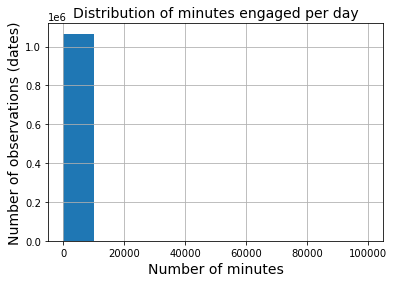

In [16]:
t1['active_mins'].hist();
plt.title('Distribution of minutes engaged per day', size=14);
plt.xlabel('Number of minutes', size=14)
plt.ylabel('Number of observations (dates)', size=14);

We can see some really weird outliers. There are only

In [17]:
60*24

1440

minutes in a given day. So we know, there are some issues with the data!

2. How many variants are there? (There should only be two, the test and the control.) How many members in each variant?

In [18]:
t2.variant_number.value_counts()

0    40000
1    10000
Name: variant_number, dtype: int64

From the above, we see 1:4 ratio, where the vast majority of users are in the control group in this rollout, and only 20% are assigned to test.

3. What is the average of active minutes (measuring engagement) in the pre-launch sample?

In [19]:
t3.active_mins.mean()

32.20315051008619

Right off the bet, we can see that the average time spent has increased after the launch, although it is not, yet, isolated for just the experiment group.

Let's do a sanity check on the outliers here as well:

In [20]:
t3[['dt','active_mins']].sort_values(
    by='active_mins',ascending=False).head()

,dt,active_mins
983858,2019-01-19,99999.0
934998,2019-01-02,99999.0
357481,2018-09-18,99999.0
211059,2019-01-19,99999.0
293885,2019-01-02,99999.0


Unfortunately, same issue here, which will need to be addressed with cleaning.

4. Let's understand the user types and distributions we are dealing with.

In [21]:
t4.gender.value_counts()

male       27757
female     14477
unknown     7766
Name: gender, dtype: int64

I am making a quick observation about the disparity in genders here. However, this may just be the distribution of users on the Quora site and not experiment specific, but we might beware of some bias if that isn't the case.

In [22]:
t4.user_type.value_counts()

non_reader     36066
reader          8002
new_user        4888
contributor     1044
Name: user_type, dtype: int64

5. I just want to confirm, there isn't anything weird or off between the user groups, to ensure merit of our experiment design. Let's look at signup dates for each cohort.

In [23]:
t2[(t2.variant_number == 0)].signup_date.value_counts()

#code reference: filtering data in Pandas: https://www.listendata.com/2019/07/how-to-filter-pandas-dataframe.html

2019-01-08    231
2019-02-04    216
2019-01-29    195
2019-02-03    185
2019-01-31    185
             ... 
2011-05-27      1
2013-03-31      1
2011-06-07      1
2011-02-27      1
2012-08-17      1
Name: signup_date, Length: 2611, dtype: int64

In [24]:
t2[(t2.variant_number == 1)].signup_date.value_counts()

2019-01-30    68
2019-02-04    67
2019-01-28    67
2019-01-22    61
2019-02-02    61
              ..
2014-10-25     1
2014-12-07     1
2011-01-24     1
2015-04-18     1
2014-05-26     1
Name: signup_date, Length: 2030, dtype: int64

I notice the range starts in 2011 for the pre-launch sample, whereas the range for the post launch sample doesn't start till 2013. There may be some disparities here, therefore, in the "newness" or novelty of the user that may impact some behavior. We should consider designing the experiments to roughly split up cohorts among similar user types, to compare apples to apples.

6. Finally, I want to understand, how many unique users we have in each group (rather than observations).

In [96]:
#strategy:
# get unique count of users for each cohort

#import SQL library for Python
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

def pysqldf(q):
    #add this to your script if you get tired of calling locals()
    return sqldf(q, globals())




q = """
    SELECT uid, COUNT(uid) AS days_active FROM t1
    GROUP BY uid           
    ORDER BY days_active DESC
         
              
"""

print(pysqldf(q).head(20))

      uid  days_active
0    9150          110
1   24028          109
2    7508          108
3   49503          107
4   48906          107
5   28355          107
6   16006          107
7    5847          107
8    3815          107
9    3313          107
10  39663          106
11  35654          106
12  35462          106
13  30000          106
14  29034          106
15  21521          106
16  14189          106
17   5691          106
18   2855          106
19  25249          105


In [97]:
#repeat same for the pre-launch group

#strategy:
# get unique count of users for each cohort


q = """
    SELECT COUNT(uid) AS days_active FROM t3
    GROUP BY uid           
    ORDER BY days_active DESC
         
              
"""

print(pysqldf(q).head(20))

    days_active
0           133
1           129
2           127
3           127
4           126
5           126
6           126
7           126
8           126
9           126
10          126
11          126
12          125
13          125
14          125
15          125
16          125
17          125
18          125
19          125


Given that the date ranges were pretty varied, there's nothing too weird about the same users appearing many times. In fact, we want our users to be daily actives, so this seems pretty normal across both our groups.

The only slight nuance might be that our most active user in the pre-launch group seemed more active than anyone in the post-launch group overall -- which might be counterintuitive, since we did see greater activity in the post-launch group. But given the earlier observed disparity in signup dates, with the pre-launch group showing longer active users, this isn't actually shocking.

Still, we might want to revisit overall retention, i.e. number of active days AFTER the experiment date!

6b. Check for retention -- consider only after experiment launch date

In [27]:
#Same query, but with the date filter for activity after experiment dates:



q = """
    SELECT COUNT(uid) AS user_count FROM t1
    WHERE dt >= '2019-02-06' 
    GROUP BY uid           
    ORDER BY user_count DESC
         
              
"""

print(pysqldf(q).head(20))

    user_count
0          110
1          109
2          108
3          107
4          107
5          107
6          107
7          107
8          107
9          107
10         106
11         106
12         106
13         106
14         106
15         106
16         106
17         106
18         106
19         105


## Questions from the form

### Unit of analysis

In order to measure the experiment effect on user engagement, let's say you want to perform a t-test of the difference in minutes spent on site, what would be your unit of analysis (i.e. when conducting a t-test, we calculate means and variances of two samples. What does each data point represent in the samples?)? 


OPTION 1: Total minutes per user in each group (number of data points in each group = number of users in that group)

*OPTION 2*: Total minutes per user per day in each group (number of data points in each group = number of users in that group x number of days of the experiment)

OPTION 3: Total minutes per group per day (number of data points in each group = number of days of the experiment)

Why do you think the other choices are not correct? Hint: think of the key assumptions of running a t-test.

From the data dictionary, we know that each observation represents engagement in active minutes spent per user, per day. We have also calculated the mean time spent per group, which is the total number of minutes across all observations (presumably, days) for each cohort. Therefore, this should be what we are comparing against.

### Conduct a t-test

Use only tables 1 (t1_user_active_min.csv) and 2 (t2_user_variant.csv) for this question. 

We suspect that there might be inaccuracies in the minutes spent on site data in some rows. Think about the definition of the metric and check if there are any outliers in the data. In this context, outliers mean numbers that are obviously different due to logging errors. If so, remove them; if not, use all the data. 

Using t-test under your assumption about variance, find an appropriate 95% confidence interval of the overall average treatment effect (using the unit of analysis you identified in the previous section).

Enter the confidence interval below. Please round your answer to second place after the decimal.

#### Cleaning for t-test

Yes, we in fact, found such rows in the EDA earlier!

Let's filter them out and create a new, clean t1:

In [28]:
t1_clean = t1[t1['active_mins']!=99999]

In [29]:
t1_clean.head()

,uid,dt,active_mins
0,0,2019-02-22,5.0
1,0,2019-03-11,5.0
2,0,2019-03-18,3.0
3,0,2019-03-22,4.0
4,0,2019-04-03,9.0


In [30]:
#verify minute ranges now make sense:
t1_clean[['dt','active_mins']].sort_values(
    by='active_mins',ascending=False).head()

,dt,active_mins
53105,2019-02-24,897.0
495393,2019-04-03,896.0
925607,2019-04-14,895.0
424321,2019-04-23,894.0
53131,2019-04-06,894.0


Let's also fix the pre-launch sample data, of the same issues:

In [31]:
t3_clean = t3[t3['active_mins']!=99999]

In [32]:
#verify minute ranges now make sense:
t3_clean[['dt','active_mins']].sort_values(
    by='active_mins',ascending=False).head()

,dt,active_mins
386278,2018-09-25,897.0
553056,2019-01-06,896.0
983780,2018-09-21,895.0
474790,2019-01-27,894.0
947093,2018-10-01,893.0


#### T-test on new data only

In [33]:
#WE SHOULD MERGE T1 + T2 TO DECIPHER, WHAT GROUP EACH USER 
#BELONGS TO



q = """ 
    SELECT t1.uid, t1.dt, t1.active_mins,
           t2.variant_number, t2.signup_date
    
    FROM t1
    LEFT JOIN t2
    ON t1.uid = t2.uid
 
              
"""

groups_assigned = pd.DataFrame(pysqldf(q))

In [34]:
groups_assigned

,uid,dt,active_mins,variant_number,signup_date
0,0,2019-02-22,5.0,0,2018-09-24
1,0,2019-03-11,5.0,0,2018-09-24
2,0,2019-03-18,3.0,0,2018-09-24
3,0,2019-03-22,4.0,0,2018-09-24
4,0,2019-04-03,9.0,0,2018-09-24
...,...,...,...,...,...
1066397,49999,2019-04-14,24.0,1,2015-12-29
1066398,49999,2019-04-26,1.0,1,2015-12-29
1066399,49999,2019-05-31,6.0,1,2015-12-29
1066400,49999,2019-06-02,2.0,1,2015-12-29


In [35]:
#clean up any bad data
groups_assigned[['dt','active_mins']].sort_values(
    by='active_mins',ascending=False).head()

,dt,active_mins
699598,2019-05-19,99999.0
424289,2019-03-10,99999.0
69742,2019-05-10,99999.0
69745,2019-05-16,99999.0
1057133,2019-03-10,99999.0


In [36]:
post_launch_clean = groups_assigned[groups_assigned['active_mins']!=99999]

In [37]:
post_launch_clean[['dt','active_mins']].sort_values(
    by='active_mins',ascending=False).head()

,dt,active_mins
53105,2019-02-24,897.0
495393,2019-04-03,896.0
925607,2019-04-14,895.0
424321,2019-04-23,894.0
53131,2019-04-06,894.0


In [38]:
rp.ttest(group1= post_launch_clean['active_mins'][post_launch_clean['variant_number'] == 0], group1_name= "control",
         group2= post_launch_clean['active_mins'][post_launch_clean['variant_number'] == 1], group2_name= "experiment")

(     Variable          N       Mean         SD        SE  95% Conf.   Interval
 0     control   886815.0  19.337660  44.797631  0.047571  19.244423  19.430897
 1  experiment   179415.0  23.526294  54.191356  0.127938  23.275538  23.777050
 2    combined  1066230.0  20.042483  46.537632  0.045069  19.954149  20.130817,
                      Independent t-test       results
 0  Difference (control - experiment) =  -4.188600e+00
 1                 Degrees of freedom =   1.066228e+06
 2                                  t =  -3.478840e+01
 3              Two side test p value =   0.000000e+00
 4             Difference < 0 p value =   0.000000e+00
 5             Difference > 0 p value =   1.000000e+00
 6                          Cohen's d =  -9.010000e-02
 7                          Hedge's g =  -9.010000e-02
 8                      Glass's delta =  -9.350000e-02
 9                        Pearson's r =   3.370000e-02)

Based on your findings, what is your recommended course of action regarding the new UI design? You can justify your choice in the next box.

*Push to production*

Do not push to production

Conduct further research

Other:

Justify your answer.

Our p-value is small, and the difference in the mean minutes spent between the two groups is significant, with experiment outperforming on engagement. The degrees of freedom are ample, which is all what we want to see to decipherably contribute the difference in behavior to more than a chance. Therefore, ship this product change!

### Add in new data from pre-launch

#### Add features for easy filtering + merge dataframes to manipulate easily

In [39]:
#add column indicating whether group is exp.
t1_clean['timing'] = 'post-launch' #REPLACE THIS SIMPLY WITH "POST-LAUNCH"

<ipython-input-39-be2c03936774>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1_clean['timing'] = 'post-launch' #REPLACE THIS SIMPLY WITH "POST-LAUNCH"


In [40]:
t1_clean.head()

,uid,dt,active_mins,timing
0,0,2019-02-22,5.0,post-launch
1,0,2019-03-11,5.0,post-launch
2,0,2019-03-18,3.0,post-launch
3,0,2019-03-22,4.0,post-launch
4,0,2019-04-03,9.0,post-launch


In [41]:
t3_clean['timing'] = 'pre-launch' #REPLACE THIS SIMPLY WITH "PRE-LAUNCH"
t3_clean.head()

<ipython-input-41-8341fa2f354b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t3_clean['timing'] = 'pre-launch' #REPLACE THIS SIMPLY WITH "PRE-LAUNCH"


,uid,dt,active_mins,timing
0,0,2018-09-24,3.0,pre-launch
1,0,2018-11-08,4.0,pre-launch
2,0,2018-11-24,3.0,pre-launch
3,0,2018-11-28,6.0,pre-launch
4,0,2018-12-02,6.0,pre-launch


In [42]:
all_obs = pd.concat([t1_clean,t3_clean])
all_obs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2256157 entries, 0 to 1190092
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   uid          int64  
 1   dt           object 
 2   active_mins  float64
 3   timing       object 
dtypes: float64(1), int64(1), object(2)
memory usage: 86.1+ MB


In [43]:
all_obs

,uid,dt,active_mins,timing
0,0,2019-02-22,5.0,post-launch
1,0,2019-03-11,5.0,post-launch
2,0,2019-03-18,3.0,post-launch
3,0,2019-03-22,4.0,post-launch
4,0,2019-04-03,9.0,post-launch
...,...,...,...,...
1190088,49999,2018-09-15,5.0,pre-launch
1190089,49999,2018-09-26,8.0,pre-launch
1190090,49999,2018-10-20,29.0,pre-launch
1190091,49999,2018-12-14,3.0,pre-launch


#### Now merge this again with t2 to split into groups

In [44]:
#WE SHOULD MERGE T1, T3 + T2 TO DECIPHER, WHAT GROUP EACH USER 
#BELONGS TO



q = """ 
    SELECT all_obs.uid, all_obs.dt, all_obs.active_mins, all_obs.timing,
           t2.variant_number, t2.signup_date
    
    FROM all_obs
    LEFT JOIN t2
    ON all_obs.uid = t2.uid
 
              
"""

groups_assigned2 = pd.DataFrame(pysqldf(q))

In [45]:
groups_assigned2

,uid,dt,active_mins,timing,variant_number,signup_date
0,0,2019-02-22,5.0,post-launch,0,2018-09-24
1,0,2019-03-11,5.0,post-launch,0,2018-09-24
2,0,2019-03-18,3.0,post-launch,0,2018-09-24
3,0,2019-03-22,4.0,post-launch,0,2018-09-24
4,0,2019-04-03,9.0,post-launch,0,2018-09-24
...,...,...,...,...,...,...
2256152,49999,2018-09-15,5.0,pre-launch,1,2015-12-29
2256153,49999,2018-09-26,8.0,pre-launch,1,2015-12-29
2256154,49999,2018-10-20,29.0,pre-launch,1,2015-12-29
2256155,49999,2018-12-14,3.0,pre-launch,1,2015-12-29


#### Now get stats from t-test from updated dataframe!

In [46]:
rp.ttest(group1= groups_assigned2['active_mins'][groups_assigned2['variant_number'] == 0], group1_name= "control",
         group2= groups_assigned2['active_mins'][groups_assigned2['variant_number'] == 1], group2_name= "experiment")

(     Variable          N       Mean         SD        SE  95% Conf.   Interval
 0     control  1876143.0  19.267363  45.148098  0.032961  19.202760  19.331967
 1  experiment   380014.0  18.279532  44.211077  0.071719  18.138966  18.420098
 2    combined  2256157.0  19.100979  44.993148  0.029954  19.042269  19.159689,
                      Independent t-test       results
 0  Difference (control - experiment) =   9.878000e-01
 1                 Degrees of freedom =   2.256155e+06
 2                                  t =   1.234240e+01
 3              Two side test p value =   0.000000e+00
 4             Difference < 0 p value =   1.000000e+00
 5             Difference > 0 p value =   0.000000e+00
 6                          Cohen's d =   2.200000e-02
 7                          Hedge's g =   2.200000e-02
 8                      Glass's delta =   2.190000e-02
 9                        Pearson's r =   8.200000e-03)

Please enter the lower bound of your confidence interval (e.g. if the confidence Interval is [-1.00, 2.00], enter -1.00)

We are expecting everything to be in + or - minutes for the confidence interval.

In [47]:
19.04

19.04

Please enter the upper bound of your confidence interval (e.g. if the confidence Interval is [-1.00, 2.00], enter 2.00)

In [48]:
19.16

19.16

This time, the experiment did worse!

### Adding in user type data

Deeper dive

In real life, experiment results can be nuanced. We provide you now additionally table 4 (t4_user_attributes.csv), which might help you analyze the results better. You should think about the context of the experiment and hypothesize why the analysis above could be insufficient. Explore the data and share with us your insights!

1. Given the new tables, were there any issues in treatment assignment? Was the treatment effect different for different covariates? 

2. Based on the new findings, what is your conclusion and what product recommendations would you make to the team?

Summarize your findings in a brief write-up with up to 200 words, and include one or two plots that best represent your results. Submit a single PDF file, please.

Strategy: Look at also using t4 for different user activities, or can use date diff btn signup date and exp date to determine newness.

In [49]:
#join in the t4 table

q = """ 
    SELECT groups_assigned2.*, t4.user_type, t4.gender
    
    FROM groups_assigned2
    LEFT JOIN t4
    ON groups_assigned2.uid = t4.uid
 
              
"""

all_users = pd.DataFrame(pysqldf(q))

In [50]:
all_users

,uid,dt,active_mins,timing,variant_number,signup_date,user_type,gender
0,0,2019-02-22,5.0,post-launch,0,2018-09-24,non_reader,male
1,0,2019-03-11,5.0,post-launch,0,2018-09-24,non_reader,male
2,0,2019-03-18,3.0,post-launch,0,2018-09-24,non_reader,male
3,0,2019-03-22,4.0,post-launch,0,2018-09-24,non_reader,male
4,0,2019-04-03,9.0,post-launch,0,2018-09-24,non_reader,male
...,...,...,...,...,...,...,...,...
2256152,49999,2018-09-15,5.0,pre-launch,1,2015-12-29,non_reader,female
2256153,49999,2018-09-26,8.0,pre-launch,1,2015-12-29,non_reader,female
2256154,49999,2018-10-20,29.0,pre-launch,1,2015-12-29,non_reader,female
2256155,49999,2018-12-14,3.0,pre-launch,1,2015-12-29,non_reader,female


In [53]:
all_users['active_mins'].mean()

19.10097878826695

### Averages by user type

Let's compare what we get for each individual subset, using our variants as well as the different user types. Also consider cross-tabs.

The hypothesis here is that we should see this classification of activity reflect in the engagement. Namely, I expect:

- The most activity from contributors
- The least activity from non-readers

This breaks down to something like this, by slice:

In [58]:
#control - non-readers

all_users.loc[
    (all_users[
        "variant_number"] == 0) & (all_users["user_type"] == 'non_reader')][
    'active_mins'
].mean()

5.929434668844137

In [59]:
#experiment - non-readers

all_users.loc[
    (all_users[
        "variant_number"] == 1) & (all_users["user_type"] == 'non_reader')][
    'active_mins'
].mean()

7.838953380464677

In [60]:
#control - readers

all_users.loc[
    (all_users[
        "variant_number"] == 0) & (all_users["user_type"] == 'reader')][
    'active_mins'
].mean()

29.393337800973406

In [61]:
#experiment - readers

all_users.loc[
    (all_users[
        "variant_number"] == 1) & (all_users["user_type"] == 'reader')][
    'active_mins'
].mean()

32.88854519485819

In [62]:
#control - new users

all_users.loc[
    (all_users[
        "variant_number"] == 0) & (all_users["user_type"] == 'new_user')][
    'active_mins'
].mean()

5.12800557556046

In [63]:
#experiment - new users

all_users.loc[
    (all_users[
        "variant_number"] == 1) & (all_users["user_type"] == 'new_user')][
    'active_mins'
].mean()

8.191169255928045

In [64]:
#control - contributors

all_users.loc[
    (all_users[
        "variant_number"] == 0) & (all_users["user_type"] == 'contributor')][
    'active_mins'
].mean()

67.16043192906066

In [65]:
#experiment -- contributors

all_users.loc[
    (all_users[
        "variant_number"] == 1) & (all_users["user_type"] == 'contributor')][
    'active_mins'
].mean()

70.48476163847337

Wow! There is a SUBSTANTIAL difference in activity across the different user types! Moreover, each slice shows a fairly substantial improvement in activity for the experiment. We should therefore stick with launching the experiment!

That is, at first glance.

Let's see, what happens if we dig a little deeper, though.

In [92]:
#from https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html

#pd.pivot_table(df, values = ['column1', 'column2'], index=['A', 'C'],
#                    aggfunc={'D': np.mean,
#                             'E': np.mean})

pivot = pd.pivot_table(
    all_users, values=['active_mins'], index=[
        'user_type', 'gender', 'variant_number'], #can also include timing but gets noisy
              aggfunc={
                  'active_mins': np.mean
              })

pivot

active_mins
user_type   gender  variant_number             
contributor female  0                 55.424233
                    1                 49.386876
            male    0                 70.228024
                    1                 78.052642
            unknown 0                 70.696211
                    1                 65.207156
new_user    female  0                  4.934810
                    1                  7.814208
            male    0                  5.297988
                    1                  8.319577
            unknown 0                  5.028816
                    1                  8.535881
non_reader  female  0                  6.044655
                    1                  7.534075
            male    0                  5.944674
                    1                  8.045673
            unknown 0                  5.670401
                    1                  7.495626
reader      female  0                 27.043428
                    1                 30.889909
            male    0                 30.369335
                    1                 33.050439
            unknown 0                 28.840462
                    1                 35.846233

Interestingly enough, the experiment performed better for each group, with the exception of contributor females and contributors of unknown gender! So, we might want to further look into why this might be the case, before rolling out the feature to contributors.

### Visualizations

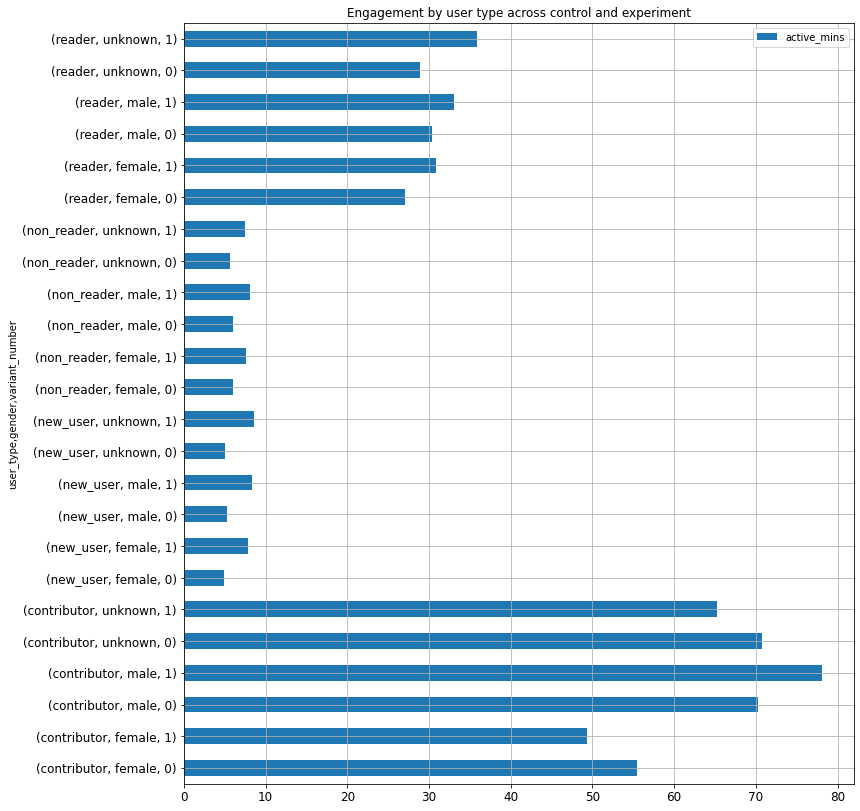

In [94]:
pivot.plot(
    kind='barh', 
    figsize = (12, 14),
    title = 'Engagement by user type across control and experiment',
    grid = 1,
    fontsize = 12
);

In [104]:
#add days or years active

q = """
    SELECT uid, 
        user_type, 
        variant_number,
        gender,
        active_mins,
        COUNT(uid) AS days_active 
        
    FROM all_users
    GROUP BY uid           
    ORDER BY days_active DESC
         
              
"""

days_active = pysqldf(q)

days_active

,uid,user_type,variant_number,gender,active_mins,days_active
0,24028,reader,0,male,112.0,235
1,9150,reader,0,male,107.0,231
2,3313,contributor,0,male,146.0,231
3,30000,contributor,0,male,246.0,230
4,39381,reader,0,male,21.0,229
...,...,...,...,...,...,...
49847,135,new_user,0,male,1.0,1
49848,126,new_user,0,female,5.0,1
49849,111,new_user,0,male,4.0,1
49850,104,new_user,0,female,3.0,1


Text(0, 0.5, 'Active minutes')

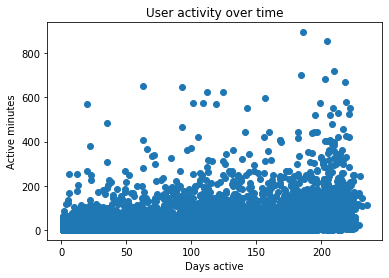

In [109]:
plt.scatter(data = days_active, x = 'days_active', y = 'active_mins');
plt.title('User activity over time')
plt.xlabel('Days active')
plt.ylabel('Active minutes')

In [115]:
pivot2 = pd.pivot_table(
    days_active, values=['active_mins', 'days_active'], index=[
        'user_type'], #, 'variant_number'], #can also include gender, timing but gets noisy
              aggfunc={
                  'active_mins': np.mean,
                  'days_active': np.mean
              })

pivot2

,active_mins,days_active
user_type,,
contributor,66.217433,134.252874
new_user,4.268445,4.863068
non_reader,4.911603,34.200567
reader,27.772307,107.619345


## Conclusions

There may have been some issues with experiment design.

There is something very bizarre in the control group's behavior. Perhaps it's seasonality or something else, but we should not be seeing such drastic changes in the control group overtime. So, this needs to be studied further.

It is also bizarre that we would see any differences between control and experiment groups prior to the launch of the experiment. This gives me pause as to how those groups were selected.

In addition, there may be other nuances with the user type classification. For instance, a user could both be new and a contributor, or a contributor and a reader. It might make sense to separate the user type from the activity level, in this case, or even have a separate category for users that fall into these multiple classes.

Finally, we might take a step back and consider, where we might want to focus. The 80/20 rule probably applies here, in that our contributors, while comprising a much smaller proportion of users, are overall our most valuable users -- without their contribution of content, there won't be anything for the readers to read, after all -- so we should be careful launching features that might dissuade our contributors from partaking on the platform.